In [1]:
import pandas as pd
import sklearn.metrics as metrique
from pandas import Series
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from matplotlib import pyplot
from sklearn.model_selection import train_test_split
import numpy as np
from keras.callbacks import EarlyStopping
from keras.utils import np_utils
from keras.callbacks import ModelCheckpoint
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report, confusion_matrix
from keras.models import Sequential
from keras.utils import np_utils
from keras.layers import LSTM, Dense, Embedding, Dropout,Input, Attention, Layer, Concatenate, Permute, Dot, Multiply, Flatten
from keras.layers import RepeatVector, Dense, Activation, Lambda
from keras.models import Sequential
from keras import backend as K, regularizers, Model, metrics
from keras.backend import cast

In [2]:
df = pd.read_csv("creditcard.csv")

In [3]:
df.shape

(284807, 31)

In [4]:
from sklearn.preprocessing import StandardScaler
# Standardisation of Time and Amount variables
df['Amount'] = StandardScaler().fit_transform(df['Amount'].values.reshape(-1, 1))
df['Time'] = StandardScaler().fit_transform(df['Time'].values.reshape(-1, 1))

In [5]:
X = df.drop(['Class'], axis=1)
y = df['Class']

In [6]:
from sklearn.model_selection import train_test_split
x_train,x_test,y_train,y_test = train_test_split(X, y, test_size=0.2, random_state=424)

In [7]:
x_train.shape

(227845, 30)

In [8]:
x_test.shape

(56962, 30)

In [9]:
## Reshape input to be 3D [samples, timesteps, features] 
x_train = np.array(x_train).reshape((x_train.shape[0], 1, x_train.shape[1]))
x_test = np.array(x_test).reshape((x_test.shape[0], 1, x_test.shape[1]))

In [10]:
class attention(Layer):
    def __init__(self,**kwargs):
        super(attention,self).__init__(**kwargs)

    def build(self,input_shape):
        self.W=self.add_weight(name="att_weight",shape=(input_shape[-1],1),initializer="normal")
        self.b=self.add_weight(name="att_bias",shape=(input_shape[1],1),initializer="zeros")        
        super(attention, self).build(input_shape)

    def call(self,x):
        et=K.squeeze(K.tanh(K.dot(x,self.W)+self.b),axis=-1)
        at=K.softmax(et)
        at=K.expand_dims(at,axis=-1)
        output=x*at
        return K.sum(output,axis=1)

    def compute_output_shape(self,input_shape):
        return (input_shape[0],input_shape[-1])

    def get_config(self):
        return super(attention,self).get_config()

In [11]:
import numpy as np
import tensorflow as tf
from keras import backend as K


def recall(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall_keras = true_positives / (possible_positives + K.epsilon())
    return recall_keras


def precision(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision_keras = true_positives / (predicted_positives + K.epsilon())
    return precision_keras


def specificity(y_true, y_pred):
    tn = K.sum(K.round(K.clip((1 - y_true) * (1 - y_pred), 0, 1)))
    fp = K.sum(K.round(K.clip((1 - y_true) * y_pred, 0, 1)))
    return tn / (tn + fp + K.epsilon())


def negative_predictive_value(y_true, y_pred):
    tn = K.sum(K.round(K.clip((1 - y_true) * (1 - y_pred), 0, 1)))
    fn = K.sum(K.round(K.clip(y_true * (1 - y_pred), 0, 1)))
    return tn / (tn + fn + K.epsilon())


def f1(y_true, y_pred):
    p = precision(y_true, y_pred)
    r = recall(y_true, y_pred)
    return 2 * ((p * r) / (p + r + K.epsilon()))


def fbeta(y_true, y_pred, beta=2):
    y_pred = K.clip(y_pred, 0, 1)

    tp = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)), axis=1)
    fp = K.sum(K.round(K.clip(y_pred - y_true, 0, 1)), axis=1)
    fn = K.sum(K.round(K.clip(y_true - y_pred, 0, 1)), axis=1)

    p = tp / (tp + fp + K.epsilon())
    r = tp / (tp + fn + K.epsilon())

    num = (1 + beta ** 2) * (p * r)
    den = (beta ** 2 * p + r + K.epsilon())
    return K.mean(num / den)


def matthews_correlation_coefficient(y_true, y_pred):
    tp = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    tn = K.sum(K.round(K.clip((1 - y_true) * (1 - y_pred), 0, 1)))
    fp = K.sum(K.round(K.clip((1 - y_true) * y_pred, 0, 1)))
    fn = K.sum(K.round(K.clip(y_true * (1 - y_pred), 0, 1)))

    num = tp * tn - fp * fn
    den = (tp + fp) * (tp + fn) * (tn + fp) * (tn + fn)
    return num / K.sqrt(den + K.epsilon())


def equal_error_rate(y_true, y_pred):
    n_imp = tf.count_nonzero(tf.equal(y_true, 0), dtype=tf.float32) + tf.constant(K.epsilon())
    n_gen = tf.count_nonzero(tf.equal(y_true, 1), dtype=tf.float32) + tf.constant(K.epsilon())

    scores_imp = tf.boolean_mask(y_pred, tf.equal(y_true, 0))
    scores_gen = tf.boolean_mask(y_pred, tf.equal(y_true, 1))

    loop_vars = (tf.constant(0.0), tf.constant(1.0), tf.constant(0.0))
    cond = lambda t, fpr, fnr: tf.greater_equal(fpr, fnr)
    body = lambda t, fpr, fnr: (
        t + 0.001,
        tf.divide(tf.count_nonzero(tf.greater_equal(scores_imp, t), dtype=tf.float32), n_imp),
        tf.divide(tf.count_nonzero(tf.less(scores_gen, t), dtype=tf.float32), n_gen)
    )
    t, fpr, fnr = tf.while_loop(cond, body, loop_vars, back_prop=False)
    eer = (fpr + fnr) / 2

    return eer

In [12]:
input1=Input((1,30))
att_in=LSTM(50,return_sequences=True,dropout=0.3,recurrent_dropout=0.2)(input1)
att_in_1=LSTM(50,return_sequences=True,dropout=0.3,recurrent_dropout=0.2)(att_in)
att_out=attention()(att_in_1)
output1=Dense(1,activation='sigmoid',trainable=True)(att_out)
model1=Model(input1,output1)

In [13]:
model1.compile(loss='binary_crossentropy', optimizer='adam', metrics=matthews_correlation_coefficient)

In [14]:
history=model1.fit(x_train, y_train,epochs=20,batch_size=64, validation_data=(x_test, y_test))

Epoch 1/20
3561/3561 [==============================] - 52s 10ms/step - loss: 0.0053 - matthews_correlation_coefficient: 0.0742 - val_loss: 4.5430e-04 - val_matthews_correlation_coefficient: 0.0708
Epoch 2/20
3561/3561 [==============================] - 35s 10ms/step - loss: 6.4507e-04 - matthews_correlation_coefficient: 0.0838 - val_loss: 4.6874e-04 - val_matthews_correlation_coefficient: 0.0708
Epoch 3/20
3561/3561 [==============================] - 31s 9ms/step - loss: 6.1573e-04 - matthews_correlation_coefficient: 0.0849 - val_loss: 4.5755e-04 - val_matthews_correlation_coefficient: 0.0708
Epoch 4/20
3561/3561 [==============================] - 46s 13ms/step - loss: 6.1169e-04 - matthews_correlation_coefficient: 0.0838 - val_loss: 4.6578e-04 - val_matthews_correlation_coefficient: 0.0708
Epoch 5/20
3561/3561 [==============================] - 49s 14ms/step - loss: 6.0359e-04 - matthews_correlation_coefficient: 0.0859 - val_loss: 4.6445e-04 - val_matthews_correlation_coefficient: 0.

In [15]:
_, train_acc = model1.evaluate(x_train, y_train, verbose=0)
_, test_acc = model1.evaluate(x_test, y_test, verbose=0)
print('Train: %.3f, Test: %.3f' % (train_acc, test_acc))

Train: 0.045, Test: 0.037


In [16]:
pred = model1.predict(x_test)
y_pred = np.round(pred)

In [17]:
y_pred

array([[0.],
       [0.],
       [0.],
       ...,
       [0.],
       [0.],
       [0.]], dtype=float32)

In [18]:
from sklearn.metrics import classification_report
from sklearn.metrics import matthews_corrcoef
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56880
           1       0.83      0.82      0.82        82

    accuracy                           1.00     56962
   macro avg       0.91      0.91      0.91     56962
weighted avg       1.00      1.00      1.00     56962



In [19]:
print(matthews_corrcoef(y_test, y_pred))

0.8218464895399966


In [20]:
from sklearn.metrics import confusion_matrix
class Visualization:
    labels = ["No-Fraud", "Fraud"]

    def draw_confusion_matrix(self, y, ypred):
        matrix = confusion_matrix(y, ypred)

        plt.figure(figsize=(10, 8))
        colors=[ "orange","green"]
        sns.heatmap(matrix, xticklabels=self.labels, yticklabels=self.labels, cmap=colors, annot=True, fmt="d")
        plt.title("Confusion Matrix")
        plt.ylabel('Actual')
        plt.xlabel('Predicted')
        plt.show()


    def draw_anomaly(self, y, error, threshold):
        groupsDF = pd.DataFrame({'error': error,
                                 'true': y}).groupby('true')

        figure, axes = plt.subplots(figsize=(12, 8))

        for name, group in groupsDF:
            axes.plot(group.index, group.error, marker='x' if name == 1 else 'o', linestyle='',
                    color='r' if name == 1 else 'g', label="Anomaly" if name == 1 else "Normal")

        axes.hlines(threshold, axes.get_xlim()[0], axes.get_xlim()[1], colors="b", zorder=100, label='Threshold')
        axes.legend()
        
        plt.title("Fraud")
        plt.ylabel("Error")
        plt.xlabel("Data")
        plt.show()

    def draw_error(self, error, threshold):
            plt.plot(error, marker='o', ms=3.5, linestyle='',
                     label='Point')

            plt.hlines(threshold, xmin=0, xmax=len(error)-1, colors="b", zorder=100, label='Threshold')
            plt.legend()
            plt.title("Reconstruction error")
            plt.ylabel("Error")
            plt.xlabel("Data")
            plt.show()

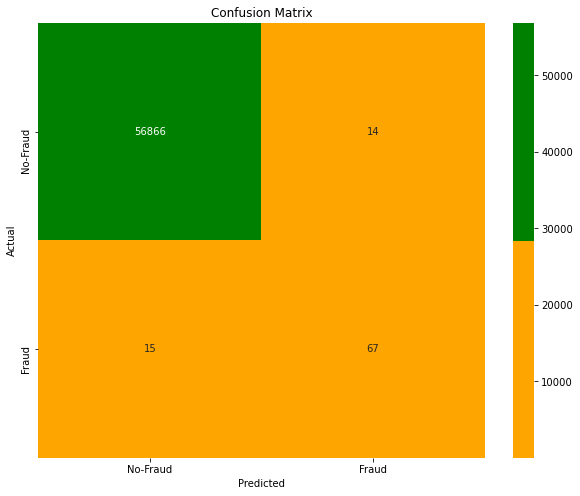

In [21]:
import matplotlib.pyplot as plt
import seaborn as sns
visualize = Visualization()
visualize.draw_confusion_matrix(y_test, y_pred)